# Определение перспективного тарифа для телеком-компании
## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

#### Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
#### Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

### Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных
#### Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя, first_name — имя пользователя, last_name — фамилия пользователя, age — возраст пользователя (годы), reg_date — дата подключения тарифа (день, месяц, год), churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), city — город проживания пользователя, tarif — название тарифного плана
#### Таблица calls (информация о звонках):
id — уникальный номер звонка, call_date — дата звонка, duration — длительность звонка в минутах, user_id — идентификатор пользователя, сделавшего звонок
#### Таблица messages (информация о сообщениях):
id — уникальный номер сообщения, message_date — дата сообщения, user_id — идентификатор пользователя, отправившего сообщение
#### Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии, mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах), session_date — дата интернет-сессии, user_id — идентификатор пользователя
#### Таблица tariffs (информация о тарифах):
tariff_name — название тарифа, rub_monthly_fee — ежемесячная абонентская плата в рублях, minutes_included — количество минут разговора в месяц, включённых в абонентскую плату, messages_included — количество сообщений в месяц, включённых в абонентскую плату, mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах), rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата), rub_per_message — стоимость отправки сообщения сверх тарифного пакета, rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Примечание. 
Если объединение таблиц командой merge приводит к ошибке dead kernell, примените join.

## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

try:
    calls = pd.read_csv('/datasets/calls.csv', sep=',')
    internet = pd.read_csv('/datasets/internet.csv', sep=',', index_col=0)  # без `Unnamed: 0`
    messages = pd.read_csv('/datasets/messages.csv', sep=',')
    tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
    users = pd.read_csv('/datasets/users.csv', sep=',')
except:
    calls = pd.read_csv('D:\IT\courses Python\yandex_practicum\\4_project_stats\\calls.csv', sep=',')
    internet = pd.read_csv('D:\IT\courses Python\yandex_practicum\\4_project_stats\\internet.csv', sep=',', index_col=0)
    messages = pd.read_csv('D:\IT\courses Python\yandex_practicum\\4_project_stats\\messages.csv', sep=',')
    tariffs = pd.read_csv('D:\IT\courses Python\yandex_practicum\\4_project_stats\\tariffs.csv', sep=',')
    users = pd.read_csv('D:\IT\courses Python\yandex_practicum\\4_project_stats\\users.csv', sep=',')
calls.info()
print('Дубликатов в calls:', calls.duplicated().sum())
display(calls.head())
internet.info()
print('Дубликатов в internet:', internet.duplicated().sum())
display(internet.head())
messages.info()
print('Дубликатов в messages:', messages.duplicated().sum())
display(messages.head())
tariffs.info()
display(tariffs.head())
users.info()
print('Дубликатов в users:', users.duplicated().sum())
print('Количество уникальных пользователей:', users['user_id'].nunique()) 
display(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
Дубликатов в calls: 0


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
Дубликатов в internet: 0


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
Дубликатов в messages: 0


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
Дубликатов в users: 0
Количество уникальных пользователей: 500


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Вывод
Файлы отредактировала в читабельный вид параметром sep.

Пропусков нигде нет, кроме таблицы users столбец churn_date.

В таблице internet два столбца с индексом.

Даты везде типа object.

Дубликатов нигде нет.

## Подготовьте данные
1) Приведите данные к нужным типам;
2) Найдите и исправьте ошибки в данных, если они есть.
Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

In [2]:
# Преобразуем в формат даты
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# Округлим минуты в звонках
calls['duration'] = np.ceil(calls['duration'])

# Разобъем по месяцам
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

### Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [3]:
# количество сделанных звонков и израсходованных минут разговора по месяцам
calls_quantity = (
    calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
    .reset_index()
    .rename(columns={'duration': 'sum_calls'})
)

# количество отправленных сообщений по месяцам
messages_quantity = (
    messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
    .reset_index()
    .rename(columns={'id': 'count_messages'})
)

# объем израсходованного интернет-трафика по месяцам
internet_quantity = (
    internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
    .reset_index()
    .rename(columns={'mb_used': 'sum_used_mb'})
)
for data in [calls_quantity, messages_quantity, internet_quantity]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3174 non-null   int64  
 1   month      3174 non-null   int64  
 2   sum_calls  3174 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 74.5 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         2717 non-null   int64
 1   month           2717 non-null   int64
 2   count_messages  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3203 non-null   int64  
 1   month        3203 non-null   int64

In [4]:
# Вычислим помесячную выручку с каждого пользователя- для этого объединим таблицы по "внешнему", чтобы все данные вошли.
total_df = (
    calls_quantity
    .merge(messages_quantity, on=['user_id', 'month'], how='outer')
    .merge(internet_quantity, on=['user_id', 'month'], how='outer')
    .merge(users, on=['user_id'], how='outer')   
)
total_df.info()
total_df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   month           3214 non-null   float64       
 2   sum_calls       3174 non-null   float64       
 3   count_messages  2717 non-null   float64       
 4   sum_used_mb     3203 non-null   float64       
 5   age             3216 non-null   int64         
 6   churn_date      189 non-null    datetime64[ns]
 7   city            3216 non-null   object        
 8   first_name      3216 non-null   object        
 9   last_name       3216 non-null   object        
 10  reg_date        3216 non-null   datetime64[ns]
 11  tariff          3216 non-null   object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(4)
memory usage: 326.6+ KB


,user_id,month,sum_calls,count_messages,sum_used_mb,age,churn_date,city,first_name,last_name,reg_date,tariff
3211,1489,10.0,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,11.0,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3213,1489,12.0,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3214,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
3215,1371,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Есть пропуски в месяцах, звонках, сообщениях, интернет-трафике, возраст и дата окончания. 

In [5]:
# Обработаем пропуски
total_df.loc[total_df['sum_calls'].isna(), 'sum_calls'] = 0
total_df.loc[total_df['count_messages'].isna(), 'count_messages'] = 0
total_df.loc[total_df['sum_used_mb'].isna(), 'sum_used_mb'] = 0
total_df['month'] = total_df['month'].fillna(12)

total_df.info()
total_df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   month           3216 non-null   float64       
 2   sum_calls       3216 non-null   float64       
 3   count_messages  3216 non-null   float64       
 4   sum_used_mb     3216 non-null   float64       
 5   age             3216 non-null   int64         
 6   churn_date      189 non-null    datetime64[ns]
 7   city            3216 non-null   object        
 8   first_name      3216 non-null   object        
 9   last_name       3216 non-null   object        
 10  reg_date        3216 non-null   datetime64[ns]
 11  tariff          3216 non-null   object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(4)
memory usage: 326.6+ KB


,user_id,month,sum_calls,count_messages,sum_used_mb,age,churn_date,city,first_name,last_name,reg_date,tariff
3211,1489,10.0,0.0,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,11.0,0.0,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3213,1489,12.0,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3214,1128,12.0,0.0,0.0,0.00,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
3215,1371,12.0,0.0,0.0,0.00,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [6]:
# вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану

def monthly_revenue(row):
    messages = row['count_messages']
    mb = row['sum_used_mb']
    tariff = row['tariff']
    calls = row['sum_calls']
    
    # Для тарифа смарт из таблицы tariffs. Интернет округлим до ГБ
    if tariff == 'smart':
        over_calls = calls - tariffs.loc[0, 'minutes_included']
        over_gb = np.ceil((mb - tariffs.loc[0, 'mb_per_month_included'])/1024)
        over_messages = messages - tariffs.loc[0, 'messages_included']
        
        if over_calls < 0: 
            over_calls = 0
        if over_gb < 0: 
            over_gb = 0
        if over_messages < 0: 
            over_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * over_messages + 
                   tariffs.loc[0, 'rub_per_gb'] * over_gb + 
                   tariffs.loc[0, 'rub_per_minute'] * over_calls + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        over_calls = calls - tariffs.loc[1, 'minutes_included']        # Рассчет для второго тарифа
        over_gb = np.ceil((mb - tariffs.loc[1, 'mb_per_month_included'])/1024)  # Округляем в ГБ в сторону увеличения
        over_messages = messages - tariffs.loc[1, 'messages_included']
        
        if over_calls < 0: 
            over_calls = 0
        if over_gb < 0: 
            over_gb = 0
        if over_messages < 0: 
            over_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * over_messages + 
                   tariffs.loc[1, 'rub_per_gb'] * over_gb + 
                   tariffs.loc[1, 'rub_per_minute'] * over_calls + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

total_df['revenue'] = total_df.apply(monthly_revenue, axis=1).astype(int)  # Округлим значения
total_df.tail(10)

,user_id,month,sum_calls,count_messages,sum_used_mb,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
3206,1473,10.0,0.0,20.0,13688.65,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950
3207,1473,11.0,0.0,14.0,21673.80,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950
3208,1473,12.0,0.0,20.0,18418.26,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1950
3209,1489,8.0,0.0,17.0,11050.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,550
3210,1489,9.0,0.0,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,950
3211,1489,10.0,0.0,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1550
3212,1489,11.0,0.0,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1150
3213,1489,12.0,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,950
3214,1128,12.0,0.0,0.0,0.00,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1950
3215,1371,12.0,0.0,0.0,0.00,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,550


In [7]:
# Посмотрим таблицу тарифов. 
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Шаг 3. Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [8]:
# Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц
means = (
    total_df
    .pivot_table(index='user_id', values=['sum_calls', 'count_messages', 'sum_used_mb', 'revenue'])
)
for user_id in users['user_id']:
    means.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
means.head()

,count_messages,revenue,sum_calls,sum_used_mb,tariff
user_id,,,,,
1000,62.0,1950.000000,320.750000,13424.038750,ultra
1001,0.0,850.000000,422.000000,16233.000000,smart
1002,10.0,1035.714286,216.714286,16576.645714,smart
1003,76.0,1950.000000,764.400000,11456.128000,ultra
1004,149.0,1950.000000,123.375000,18629.935000,ultra


In [9]:
# Найдем среднее, стандартное отклонение и дисперсию:
total_df.pivot_table(index='tariff', values=['sum_calls', 'count_messages', 'sum_used_mb'], aggfunc=['mean', 'var', 'std'])

mean                                      var                 \
       count_messages   sum_calls   sum_used_mb count_messages      sum_calls   
tariff                                                                          
smart       33.369058  417.747534  16201.118655     796.955256   36281.393836   
ultra       49.313387  526.089249  19449.059970    2285.417425  101052.493549   

                                std                            
         sum_used_mb count_messages   sum_calls   sum_used_mb  
tariff                                                         
smart   3.456484e+07      28.230396  190.476754   5879.187315  
ultra   1.020321e+08      47.806040  317.887549  10101.095459

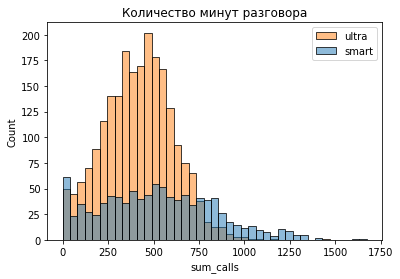

In [10]:
# Построим гистограммы - общее сравнение по тарифам. 
import seaborn as sns

sns.histplot(data=total_df, x='sum_calls', hue='tariff').set(title='Количество минут разговора')
plt.legend(['ultra', 'smart'])

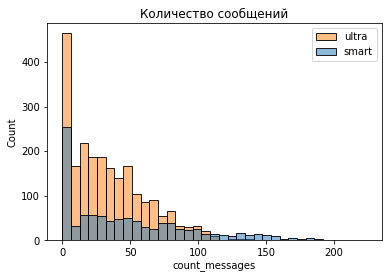

In [11]:
sns.histplot(data=total_df, x='count_messages', hue='tariff').set(title='Количество сообщений')
plt.legend(['ultra', 'smart'])

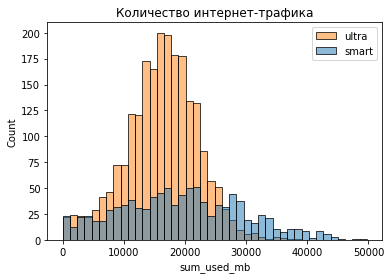

In [12]:
sns.histplot(data=total_df, x='sum_used_mb', hue='tariff').set(title='Количество интернет-трафика')
plt.legend(['ultra', 'smart'])

По тарифу смарт средние значения размазаны, в отличие от ультра, где есть пики. График сообщений имеет смещение моды и медианы влево от среднего.

### Вывод
По тарифу смарт включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика. 
По тарифу ультра включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.

- Гистограммы тарифа смарт широкие, пользователям не хватает пакета тарифа. Они переплачивают за минуты, смс и интернет.
- В то время, как тариф ультра имеет характерные пики. Количество минут тарифа ультра 500-600 - уходит большинству пользователям в месяц. Никто не наговаривает на 3000, максимальное количество 1750.
- Гистограммы сообщений смещены влево. По тарифу ультра максимальное количество укладывается до 50 смс в месяц. Тариф смарт размазан до 100 смс/месяц.
- Интернет-трафика не хватает обоим тарифам. Сильнее страдают пользователи тарифа смарт, где ГБ дороже, а нужно им около 30000 мб. По средним показателям, смарт-пользователям нужно больше 16000 мб

## Шаг 4. Проверьте гипотезы
1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; 
2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 
Пороговое значение alpha задайте самостоятельно.
### Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

#### Сформулируем нулевую гипотезу:
Первая гипотеза- средняя выручка пользователей тарифов «Ультра» и «Смарт» равна. И вторая гипотеза- средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 
#### Альтернативная гипотеза:
Вторая гипотеза -средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна. И вторая гипотеза - средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов. 

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

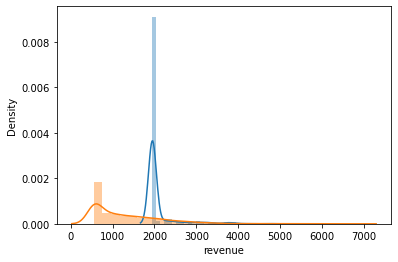

In [13]:
# Cтатистический анализ выборок двух генеральных совокупностей на проверку средней выручки по тарифам. 
# Поскольку вычесленные дисперсии разные, генеральные совокупности не зависят друг от друга и 
# выборочные средние должны быть нормально распределены. Посмотрим на графике.
ultra = total_df.query('tariff == "ultra"')['revenue']
smart = total_df.query('tariff == "smart"')['revenue']
sns.distplot(ultra, bins= 30)
sns.distplot(smart, bins= 30)

In [14]:
# Для проверки статистической гипотезы использовала критерий значимости (альфа) равный 5%. 
# Даже если бы поставила минимальную 1%, все равно бы отвергли нулевую гипотезу.
alpha= 0.05
results = st.ttest_ind(
    smart, 
    ultra, 
    equal_var=False
)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


In [15]:
# Проверим вторую гипотезу. Нулевая гипотеза гласит: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 
total_df_moscow = total_df.query('city == "Москва"').reset_index(drop=True)
total_df_cities = total_df.query('city != "Москва"').reset_index(drop=True)
alpha= 0.05
results = st.ttest_ind(
    total_df_moscow['revenue'],
    total_df_cities['revenue'],
    equal_var=False
)
print('р-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение:  0.5216952110000279
Не получилось отвергнуть нулевую гипотезу


In [16]:
# Выборки генеральных совокупностей не зависят друг от друга и имеют разный размер 611 и 2605. 
# Поэтому будем счиатать, что дисперсии не равны (equal_var=False).
total_df_moscow.info()
total_df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         611 non-null    int64         
 1   month           611 non-null    float64       
 2   sum_calls       611 non-null    float64       
 3   count_messages  611 non-null    float64       
 4   sum_used_mb     611 non-null    float64       
 5   age             611 non-null    int64         
 6   churn_date      41 non-null     datetime64[ns]
 7   city            611 non-null    object        
 8   first_name      611 non-null    object        
 9   last_name       611 non-null    object        
 10  reg_date        611 non-null    datetime64[ns]
 11  tariff          611 non-null    object        
 12  revenue         611 non-null    int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 62.2+ KB
<class 'pandas.core.frame.DataFra

### Вывод.
Первую нулевую гипотезу отвергаем. Вторую нулевую гипотезу не получилось отвергнуть.

## Общий вывод
Данные таблицах отредактированы. Пропусков и дубликатов нет.

Данные приведены в нужный формат: тип object в датах, мегабайты в гигабайты, разбиты по месяцам.

Собраны сводные таблицы по звонкам, сообщениям и гигабайтам по месяцам. Объединили их в одну с таблицей пользователей. 
Вычислили помесячную выручку с помощью цикла.

Отдельно по каждому тарифу проанализировала звонки, сообщения и интернет-трафик по месяцам. Все они нормально распределены. График сообщений смещен влево- медиана будет меньше среднего. 

По тарифу смарт идет превышение по всем показателям в месяц. По тарифу ультра- звонки и сообщения не используются в полном объеме, в то время как интернет-трафика не хватает.

<b>Тариф ультра приносит больше денег. Но он не используется в своем максимуме. Тариф смарт имеет небольшой объем единиц и людям его не хватает, переплачивают. Здесь нет лучшего тарифа для людей. Есть выгодный для бизнеса.
    Есть предложение нового тарифа- с интернетом в 30 гб, звонками- 600 звонков, 150 сообщений.

Проверены гипотезы. 
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна.
- Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 